In [1]:
import numpy as np
import gurobipy as gp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import warnings
warnings.filterwarnings("ignore") 


In [29]:
gurobi_time_limit = 3600

Our objective is to devise a strategy for selecting stocks and determining their corresponding weights to construct a fund that replicates the NASDAQ-100 index. This involves identifying stocks with strong return correlations to serve as representatives of the entire index, enabling us to track the index with a smaller subset of its constituents. Our aim is to pinpoint the specific stocks and their respective weights for our fund's portfolio, as well as determining the optimal number of stocks to minimize the absolute deviation of returns when compared to the underlying index.

To achieve this, we will be conducting a thorough analysis of NASDAQ-100 returns in 2019, laying the groundwork for a passive investment strategy aligned with our desired outcomes. Subsequently, we will utilize the index returns in 2020 as a benchmark to evaluate the performance of our passive strategy.

Our approach involves a multi-step process, starting with an integer program designed to select stocks based on their correlations. Subsequently, we employ a linear programming technique to calculate the optimal weights for these selected stocks. To further refine our strategy, we intend to explore a mixed integer program method to identify the most effective solution.

By undertaking these steps, we aim to construct an efficient and data-driven approach to mirror the NASDAQ-100 index with precision.

***

Reading the 2019 Stock File

***

In [2]:
stocks_2019 = pd.read_csv("stocks2019.csv")


In [3]:
#Storing the names of the stocks available
stocks_available = stocks_2019.columns[2:]

stocks_available

Index(['ATVI', 'ADBE', 'AMD', 'ALXN', 'ALGN', 'GOOGL', 'GOOG', 'AMZN', 'AMGN',
       'ADI', 'ANSS', 'AAPL', 'AMAT', 'ASML', 'ADSK', 'ADP', 'BIDU', 'BIIB',
       'BMRN', 'BKNG', 'AVGO', 'CDNS', 'CDW', 'CERN', 'CHTR', 'CHKP', 'CTAS',
       'CSCO', 'CTXS', 'CTSH', 'CMCSA', 'CPRT', 'COST', 'CSX', 'DXCM', 'DOCU',
       'DLTR', 'EBAY', 'EA', 'EXC', 'EXPE', 'FB', 'FAST', 'FISV', 'GILD',
       'IDXX', 'ILMN', 'INCY', 'INTC', 'INTU', 'ISRG', 'JD', 'KLAC', 'KHC',
       'LRCX', 'LBTYA', 'LBTYK', 'LULU', 'MAR', 'MXIM', 'MELI', 'MCHP', 'MU',
       'MSFT', 'MRNA', 'MDLZ', 'MNST', 'NTES', 'NFLX', 'NVDA', 'NXPI', 'ORLY',
       'PCAR', 'PAYX', 'PYPL', 'PEP', 'PDD', 'QCOM', 'REGN', 'ROST', 'SGEN',
       'SIRI', 'SWKS', 'SPLK', 'SBUX', 'SNPS', 'TMUS', 'TTWO', 'TSLA', 'TXN',
       'TCOM', 'ULTA', 'VRSN', 'VRSK', 'VRTX', 'WBA', 'WDAY', 'WDC', 'XEL',
       'XLNX'],
      dtype='object')

***

Reading the 2020 Stock File

***

In [ ]:
stocks_2020 = pd.read_csv("stocks2020.csv")

In [ ]:
#get the number of stock returns
no_of_rows = len(stocks_2019)

no_of_rows_2020 = len(stocks_2020)

<div class="alert alert-block alert-info">
    
<strong>Q1:</strong> 

In [4]:
#Calculating the Returns for the stocks for the 2019 file
for stock_name in stocks_available:
    stocks_2019[stock_name+"_return"] = (stocks_2019[stock_name] - stocks_2019[stock_name].shift(1)).fillna(0)/stocks_2019[stock_name].shift(1).fillna(1)

In [ ]:
#Calculating the Returns for the Nasdaq Return for 2019
Index_column_name = stocks_2019.columns[1]

stocks_2019[Index_column_name+"_return"] = (stocks_2019[Index_column_name] - stocks_2019[Index_column_name].shift(1)).fillna(0)/stocks_2019[Index_column_name].shift(1).fillna(1)

In [ ]:
#Calculating the Returns for the stocks and the Nasdaq Return for 2020
for stock_name in stocks_available:
    stocks_2020[stock_name+"_return"] = (stocks_2020[stock_name] - stocks_2020[stock_name].shift(1)).fillna(0)/stocks_2020[stock_name].shift(1).fillna(1)

stocks_2020[Index_column_name+"_return"] = (stocks_2020[Index_column_name] - stocks_2020[Index_column_name].shift(1)).fillna(0)/stocks_2020[Index_column_name].shift(1).fillna(1)

In [5]:
#Calculating the correlation between the available individual stocks
corr_matrix = pd.DataFrame(index=stocks_available, columns=stocks_available)

for i in stocks_available:
    for j in stocks_available:
        correlation = stocks_2019[i+"_return"][1:].corr(stocks_2019[j+"_return"][1:])
        corr_matrix[i][j]=correlation

corr_matrix.head()

,ATVI,ADBE,AMD,ALXN,ALGN,GOOGL,GOOG,AMZN,AMGN,ADI,...,TCOM,ULTA,VRSN,VRSK,VRTX,WBA,WDAY,WDC,XEL,XLNX
ATVI,1.0,0.399939,0.365376,0.223162,0.21628,0.433097,0.426777,0.467076,0.203956,0.329355,...,0.322906,0.128241,0.46485,0.316549,0.259679,0.218149,0.311659,0.303077,0.043389,0.249667
ADBE,0.399939,1.0,0.452848,0.368928,0.36337,0.552125,0.540404,0.598237,0.291978,0.473815,...,0.360392,0.201151,0.711339,0.541243,0.402171,0.228106,0.65043,0.361516,0.207403,0.289497
AMD,0.365376,0.452848,1.0,0.301831,0.344252,0.418861,0.417254,0.549302,0.151452,0.503733,...,0.332776,0.210623,0.498342,0.3309,0.272983,0.28195,0.407626,0.438892,0.017283,0.47801
ALXN,0.223162,0.368928,0.301831,1.0,0.332433,0.315993,0.307698,0.36317,0.342022,0.31704,...,0.257143,0.408936,0.350581,0.191489,0.522423,0.19272,0.416396,0.289908,0.047947,0.200356
ALGN,0.21628,0.36337,0.344252,0.332433,1.0,0.248747,0.250316,0.399281,0.264599,0.32828,...,0.175957,0.128559,0.360886,0.251855,0.334978,0.219595,0.308968,0.284407,0.088059,0.253934


<div class="alert alert-block alert-info">
    
<strong>Q2:</strong> 

For the first part of this optimization problem, our objective is to maximize the correlation between our m-stock portfolio. We work with 100 {stocks_model_present_X} binary variables and 10,000 {best_stock_X} binary variables to achieve this goal.

- The {stocks_model_present_X} variables represent whether a stock is included in our m-stock fund.
- The {best_stock_X} variables determine whether stock j is the most similar to stock i.

To satisfy the necessary constraints:

1. The first constraint ensures that exactly m stocks must be present in our m-stock fund.
   ∑ {stocks_model_present_X}[j] = m, for j = 1 to n

2. The second constraint dictates that each stock i can be "most similar" to only one stock j.
   ∑ {best_stock_X}[i,j] = 1, for i = 1, 2, ..., n, and j = 1 to n

3. The third constraint {best_stock_X}[i,j] <={stocks_model_present_X}[i] ensures that the similarity between stock i and j can exist only if stock j is selected for the m-stock fund.
   {best_stock_X}[i,j] <={stocks_model_present_X}[i], for i, j = 1 to n

4. The last constraint defines that {stocks_model_present_X} and {best_stock_X} can only take values of 0 or 1. This binary nature is set directly in Gurobi, rather than explicitly in the constraint matrix.

In [6]:
#Setting the number of stocks for the fund
m = 5

In [7]:
#initializing the model in Gurobi
stocks_model=gp.Model()

#Creating the decision variables for the model. 
stocks_model_present_X = stocks_model.addMVar(len(stocks_available),vtype='B')

best_stock_X = stocks_model.addMVar((len(stocks_available),len(stocks_available)), vtype='B')

#Adding the objective function for the model
stocks_model.setObjective(gp.quicksum(best_stock_X[i,j]*corr_matrix.iloc[i][j] for i in range(len(stocks_available)) for j in range(len(stocks_available))),sense=gp.GRB.MAXIMIZE)

#Adding the constraints for the model
stocks_model_cons=[0]*3

stocks_model_cons[0] = stocks_model.addConstr(gp.quicksum(stocks_model_present_X[i] for i in range(len(stocks_available)) ) == m)
stocks_model_cons[1] = stocks_model.addConstrs(gp.quicksum(best_stock_X[i,j] for i in range(len(stocks_available)) )== 1 for j in range(len(stocks_available)) )
stocks_model_cons[2] = stocks_model.addConstrs(best_stock_X[i,j] <=stocks_model_present_X[i] for j in range(len(stocks_available)) for i in range(len(stocks_available)))

stocks_model.Params.OutputFlag = 0 # tell gurobi to shut up!!
stocks_model.optimize() #Solving the model

print("Optimzation Status is :",stocks_model.Status)

# print the optimal decision variable as a datafram for easy understanding
stocks_model_present_X.x

Set parameter Username


Academic license - for non-commercial use only - expires 2024-08-22
Optimzation Status is : 2


array([-0., -0.,  0.,  0., -0., -0., -0.,  0.,  0., -0.,  0.,  0., -0.,
       -0.,  0., -0.,  0.,  0., -0., -0., -0., -0.,  0.,  0., -0., -0.,
       -0., -0., -0.,  0., -0.,  0.,  0., -0., -0.,  0., -0.,  0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0.,  0.,  1., -0., -0.,  1., -0., -0., -0.,  1., -0.,
       -0.,  0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,  0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0.,  0., -0., -0., -0., -0.,
       -0., -0., -0.,  1., -0., -0., -0.,  1., -0.])

In [30]:
#show the selected stocks 
selected_stocks = stocks_available[np.where(stocks_model_present_X.x)]
selected_stocks_position = np.where(stocks_model_present_X.x) 

selected_stocks

Index(['LBTYK', 'MXIM', 'MSFT', 'VRTX', 'XEL'], dtype='object')

Now, that the stocks have been selected, we will try to determine the weight contribution for the same.

For this optimization problem, our objective is to minimize the difference between our m-stock portfolio and the entire index. We work with 251 {stocks_return_difference_X} continuous variables and m {stocks_weight_X} continuous variables to achieve this goal.

- The {stocks_return_difference_X} variables represent the difference between the m-stock portfolio and the entire index for a particular day.
- The {stocks_weight_X} variables represent the weight contribution of the selected stock to the m-stock fund.

To satisfy the necessary constraints:

1. The first constraint ensures that m stocks weights must add up to 1.
   ∑ stocks_weight_X[i] = 1, for i = 1 to m

2. The second constraint is on part to ensure the non-linearity constraint for the minimization of the stock return difference.
   stocks_return_difference_X[i]>= q[i] - ∑ stocks_weight_X[j]*r𝑖t i = 1, 2, ..., n, and j = 1 to n

3. The third constraint is on part to ensure the non-linearity constraint for the minimization of the stock return difference.
   stocks_return_difference_X[i]>= -q[i] + ∑ stocks_weight_X[j]*r𝑖t i = 1, 2, ..., n, and j = 1 to n


In [31]:
#initializing the model in Gurobi
stocks_weight_model=gp.Model()

#Creating the decision variables for the model
stocks_return_difference_X = stocks_weight_model.addMVar(no_of_rows,vtype='C')

stocks_weight_X = stocks_weight_model.addMVar(m,vtype='C')

#Adding the objective function for the model
stocks_weight_model.setObjective(gp.quicksum(stocks_return_difference_X[i] for i in range(no_of_rows)),sense=gp.GRB.MINIMIZE)

#Adding the constraints for the model
stocks_weight_cons=[0]*3

stocks_weight_cons[0] = stocks_weight_model.addConstr(gp.quicksum(stocks_weight_X[i] for i in range(m)) == 1)
stocks_weight_cons[1] = stocks_weight_model.addConstrs(stocks_return_difference_X[i]>= stocks_2019[Index_column_name+"_return"][i] - gp.quicksum(stocks_weight_X[j]*stocks_2019.iloc[i,selected_stocks_position[0][j]+ 2+ len(stocks_available)] for j in range(m) ) for i in range(no_of_rows))
stocks_weight_cons[2] = stocks_weight_model.addConstrs(stocks_return_difference_X[i]>= - stocks_2019[Index_column_name+"_return"][i] + gp.quicksum(stocks_weight_X[j]*stocks_2019.iloc[i,selected_stocks_position[0][j]+ 2+ len(stocks_available)] for j in range(m) ) for i in range(no_of_rows))


stocks_weight_model.Params.OutputFlag = 0 # tell gurobi to shut up!!
stocks_weight_model.optimize() #Solving the model

print("Optimization Status is :",stocks_weight_model.Status)

#show the optimum weights
stocks_weight_X.x

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Optimization Status is : 2


array([0.04886175, 0.21038806, 0.58035198, 0.07119022, 0.089208  ])

Here, we see that Microsoft has the highest weight. It is then followed by Maxim Integrated.

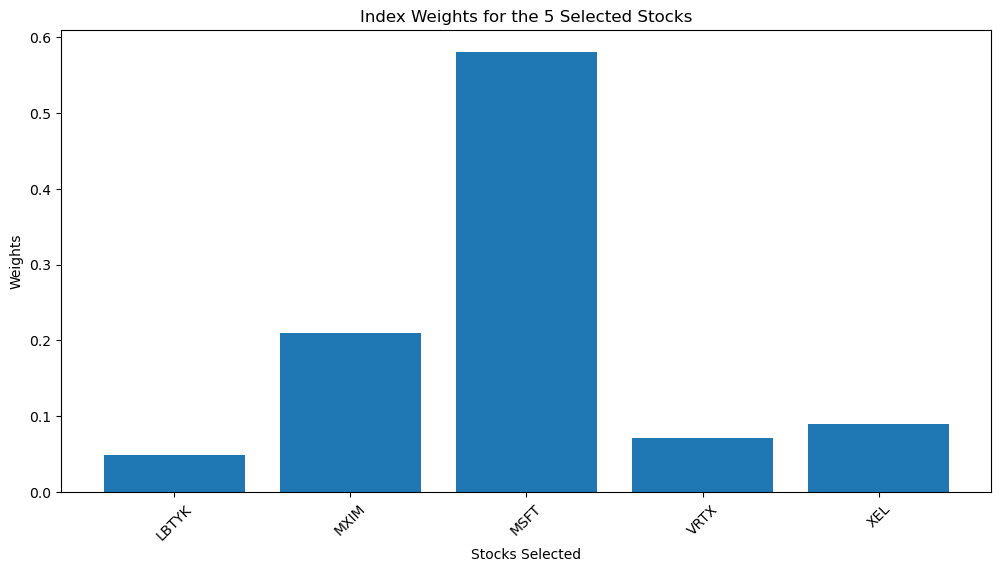

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(selected_stocks, stocks_weight_X.x)
plt.title("Index Weights for the 5 Selected Stocks")
plt.xlabel("Stocks Selected")
plt.ylabel("Weights")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

In [16]:
# Calculate the absolute deviation of the index fund 
absolute_deviation_2019 = sum(abs(stocks_2019.iloc[i][Index_column_name+"_return"] - sum(stocks_weight_X.x[j] * stocks_2019.iloc[i][selected_stocks_position[0][j]+2+len(stocks_available)] for j in range(m)))
                               for i in range(no_of_rows))

print("Absolute Deviation for 2019: ", absolute_deviation_2019)



# Calculate the absolute deviation of the index fund from NASDAQ for 2020
absolute_deviation_2020 = sum(abs(stocks_2020.iloc[i][Index_column_name+"_return"] - sum(stocks_weight_X.x[j] * stocks_2020.iloc[i][selected_stocks_position[0][j]+2+len(stocks_available)] for j in range(m)))
                               for i in range(no_of_rows_2020))

print("Absolute Deviation for 2019: ", absolute_deviation_2020)


Absolute Deviation for 2019:  0.789178282463145
Absolute Deviation for 2019:  1.112437345507646


<Axes: title={'center': 'Performance Evaluation on m=5'}, xlabel='Year', ylabel='Total Absolute Deviation'>

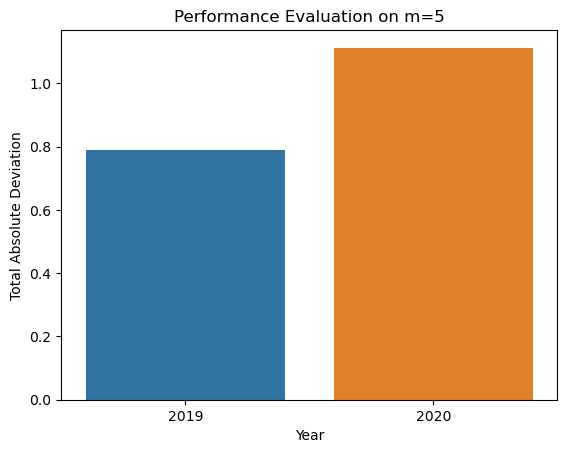

In [17]:
plt.title("Performance Evaluation on m=5")
plt.xlabel("Year")
plt.ylabel("Total Absolute Deviation")
sn.barplot(x = [2019,2020], y = [absolute_deviation_2019,absolute_deviation_2020])

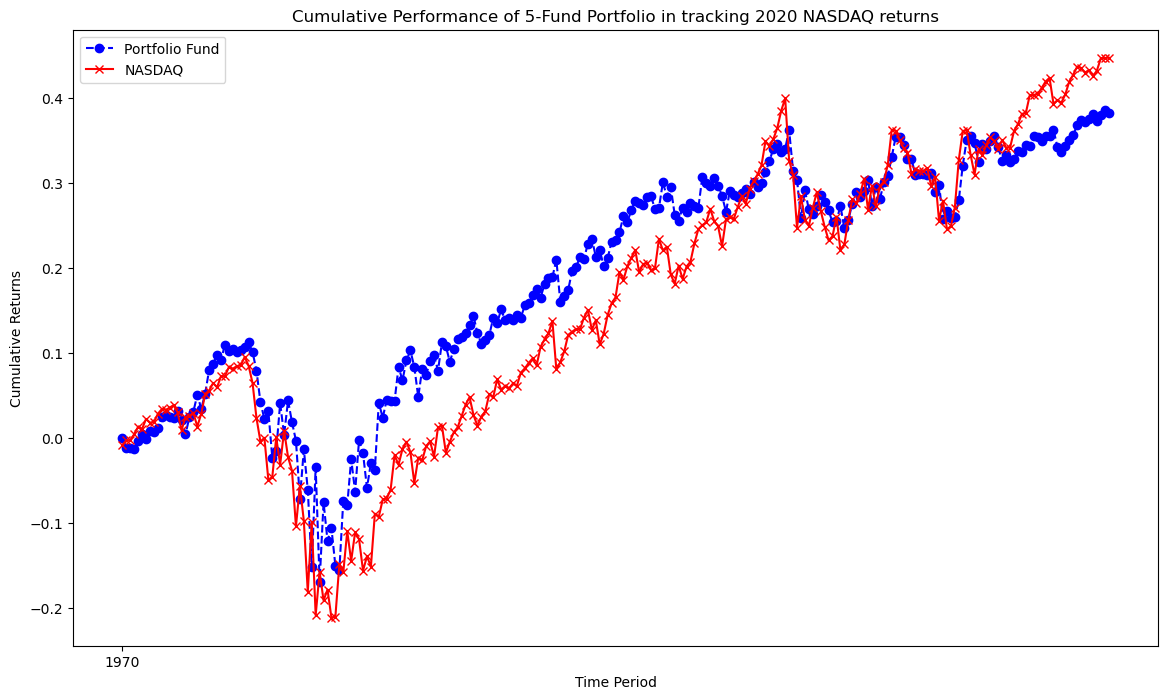

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

returns_timeline = pd.to_datetime(stocks_2020.index)
weighted_returns = []

# Computing weighted returns
cumulative_portfolio_returns = []  # Store cumulative returns here
cumulative_portfolio_return = 0

for i in range(no_of_rows):
    wr = 0
    for j in range(len(selected_stocks)):
        wr = wr + (stocks_weight_X.x[j] * stocks_2020.iloc[i][selected_stocks_position[0][j]+2+len(stocks_available)])
    weighted_returns.append(wr)
    cumulative_portfolio_return = cumulative_portfolio_return + wr  # Accumulate daily returns
    cumulative_portfolio_returns.append(cumulative_portfolio_return)

# Ensure both arrays have the same length
if len(returns_timeline) > len(cumulative_portfolio_returns):
    returns_timeline = returns_timeline[:-1]  # Remove the last date
elif len(cumulative_portfolio_returns) > len(returns_timeline):
    cumulative_portfolio_returns = cumulative_portfolio_returns[:-1]  # Remove the last value

# Calculate cumulative returns for NASDAQ
cumulative_nasdaq_returns = np.cumprod(1 + stocks_2020[Index_column_name+"_return"][1:]) - 1

# Plotting
plt.figure(figsize=(14, 8))
plt.plot(returns_timeline, cumulative_portfolio_returns, marker='o', linestyle='dashed', color='blue', label='Portfolio Fund')
plt.plot(returns_timeline, cumulative_nasdaq_returns, marker='x', color='red', label='NASDAQ')

plt.title("Cumulative Performance of 5-Fund Portfolio in tracking 2020 NASDAQ returns")
plt.xlabel('Time Period')
plt.ylabel('Cumulative Returns')
plt.legend()

plt.show()


The 5 Stock Portfolio does a fairly reasonable job of tracking the daily returns of the NASDAQ index for the year 2020.

After running the model with m = 5. It was found that the five most significant stocks of the index are Liberty Global PLC (multinational telecommunications company), Maxim Integrated (analog and mixed-signal integrated circuits company), Microsoft (multinational technology corporation), Vertex Pharmaceuticals Incorporated (a biopharmaceutical company), Xcel Energy Inc (utility holding company) 

To initiate our analysis, we initially set 'm' to 5 and utilized the 2019 dataset to identify which stocks our model selected. The selected stocks, along with their respective company and industry, are as follows:

| Stocks Selected | Company                              | Industry              |
|-----------------|-------------------------------------|-----------------------|
| LBTYK           | Liberty Global PLC                   | Telecommunications     |
| MXIM            | Maxim Integrated                     | Semiconductors         |
| MSFT            | Microsoft Corporation                | Information Technology |
| VRTX            | Vertex Pharmaceuticals Inc            | Healthcare             |
| XEL             | Xcel Energy Inc                      | Utilities              |

Notably, when examining the stocks chosen by our Integer program, we observe that each stock belongs to a distinct sector. Given the limitation of having only five stocks in our portfolio, diversification is crucial. Using the outcomes derived from the Integer program, we proceeded to determine the weights for the selected stocks by resolving the linear problem as previously described. The resulting stock weights are as follows:

| Stocks Selected | Weights  |
|-----------------|----------|
| LBTYK           | 0.048862 |
| MXIM            | 0.210388 |
| MSFT            | 0.580352 |
| VRTX            | 0.071190 |
| XEL             | 0.089208 |

It's important to note that in the NASDAQ-100 index, a significant portion of the weight is attributed to technology giants like Apple, Google, and Microsoft. In practical terms, assigning a considerable weight to Microsoft in our portfolio is a strategic choice. It effectively aligns our portfolio with the composition of the NASDAQ-100 index, as it mirrors the weightings of key constituents, such as Microsoft, within the index. This strategic weighting allows our portfolio to closely mimic the performance and characteristics of the NASDAQ-100, which is desirable for replicating the index's behavior.

<div class="alert alert-block alert-info">
    
<strong>Q3:</strong> 

In [20]:
#Setting the number of stocks for the fund
no_of_selected_stocks = [10, 20, 30, 40 ,50, 60, 70, 80, 90, 100]

no_of_stocks=[]
abs_deviation_2019=[]
abs_deviation_2020=[]

for m in no_of_selected_stocks:

    #initializing the model in Gurobi
    stocks_model=gp.Model()

    #Creating the decision variables for the model. 
    stocks_model_present_X = stocks_model.addMVar(len(stocks_available),vtype='B')

    best_stock_X = stocks_model.addMVar((len(stocks_available),len(stocks_available)), vtype='B')

    #Adding the objective function for the model
    stocks_model.setObjective(gp.quicksum(best_stock_X[i,j]*corr_matrix.iloc[i][j] for i in range(len(stocks_available)) for j in range(len(stocks_available))),sense=gp.GRB.MAXIMIZE)

    #Adding the constraints for the model
    stocks_model_cons=[0]*3

    stocks_model_cons[0] = stocks_model.addConstr(gp.quicksum(stocks_model_present_X[i] for i in range(len(stocks_available)) ) == m)
    stocks_model_cons[1] = stocks_model.addConstrs(gp.quicksum(best_stock_X[i,j] for i in range(len(stocks_available)) )== 1 for j in range(len(stocks_available)) )
    stocks_model_cons[2] = stocks_model.addConstrs(best_stock_X[i,j] <=stocks_model_present_X[i] for j in range(len(stocks_available)) for i in range(len(stocks_available)))

    stocks_model.Params.OutputFlag = 0 # tell gurobi to shut up!!
    stocks_model.optimize() #Solving the model


    #show the selected stocks 
    selected_stocks = stocks_available[np.where(stocks_model_present_X.x)]
    selected_stocks_position = np.where(stocks_model_present_X.x) 

    #get the number of stock returns
    no_of_rows = len(stocks_2019)
    no_of_rows_2020 = len(stocks_2020)

    Index_column_name = stocks_2019.columns[1]

    #initializing the model in Gurobi
    stocks_weight_model=gp.Model()

    #Creating the decision variables for the model
    stocks_return_difference_X = stocks_weight_model.addMVar(no_of_rows,vtype='C')

    stocks_weight_X = stocks_weight_model.addMVar(m,vtype='C')

    #Adding the objective function for the model
    stocks_weight_model.setObjective(gp.quicksum(stocks_return_difference_X[i] for i in range(no_of_rows)),sense=gp.GRB.MINIMIZE)

    #Adding the constraints for the model
    stocks_weight_cons=[0]*3

    stocks_weight_cons[0] = stocks_weight_model.addConstr(gp.quicksum(stocks_weight_X[i] for i in range(m)) == 1)
    stocks_weight_cons[1] = stocks_weight_model.addConstrs(stocks_return_difference_X[i]>= stocks_2019[Index_column_name+"_return"][i] - gp.quicksum(stocks_weight_X[j]*stocks_2019.iloc[i,selected_stocks_position[0][j]+ 2+ len(stocks_available)] for j in range(m) ) for i in range(no_of_rows))
    stocks_weight_cons[2] = stocks_weight_model.addConstrs(stocks_return_difference_X[i]>= - stocks_2019[Index_column_name+"_return"][i] + gp.quicksum(stocks_weight_X[j]*stocks_2019.iloc[i,selected_stocks_position[0][j]+ 2+ len(stocks_available)] for j in range(m) ) for i in range(no_of_rows))


    stocks_weight_model.Params.OutputFlag = 0 # tell gurobi to shut up!!
    stocks_weight_model.optimize() #Solving the model

    print("Optimization Status is :",stocks_weight_model.Status)

    # Calculate the absolute deviation of the index fund 
    absolute_deviation_2019 = sum(abs(stocks_2019.iloc[i][Index_column_name+"_return"] - sum(stocks_weight_X.x[j] * stocks_2019.iloc[i][selected_stocks_position[0][j]+2+len(stocks_available)] for j in range(m)))
                                for i in range(no_of_rows))

    print("Absolute Deviation for 2019: ", absolute_deviation_2019)

    # Calculate the absolute deviation of the index fund from NASDAQ for 2020
    absolute_deviation_2020 = sum(abs(stocks_2020.iloc[i][Index_column_name+"_return"] - sum(stocks_weight_X.x[j] * stocks_2020.iloc[i][selected_stocks_position[0][j]+2+len(stocks_available)] for j in range(m)))
                                for i in range(no_of_rows_2020))

    print("Absolute Deviation for 2020: ", absolute_deviation_2020)

    no_of_stocks.append(m)
    abs_deviation_2019.append(absolute_deviation_2019)
    abs_deviation_2020.append(absolute_deviation_2020)


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Optimization Status is : 2
Absolute Deviation for 2019:  0.7012177959266286
Absolute Deviation for 2020:  1.1024044007150982
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Optimization Status is : 2
Absolute Deviation for 2019:  0.478935999734257
Absolute Deviation for 2020:  0.8985819964487153
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Optimization Status is : 2
Absolute Deviation for 2019:  0.41827919321188384
Absolute Deviation for 2020:  0.7712098766576536
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Optimization Status is : 2
Absolute Deviation for 2019:  0.36743892409791096
Absolute Deviation for 2020:  0.7883347431874975
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Optimization Status is : 2
Absolute Deviation for 2019:  0.33254009291547587
Absolute Deviation for 2020:  0.

In [21]:
abs_deviation_stock_selection_df= pd.DataFrame({"no_of_stocks": no_of_stocks, "abs_deviation_2019":abs_deviation_2019, "abs_deviation_2020":abs_deviation_2020})

abs_deviation_stock_selection_df

,no_of_stocks,abs_deviation_2019,abs_deviation_2020
0,10,0.701218,1.102404
1,20,0.478936,0.898582
2,30,0.418279,0.771210
3,40,0.367439,0.788335
4,50,0.332540,0.772100
5,60,0.346033,1.167648
6,70,0.233002,0.858428
7,80,0.148219,0.545540
8,90,0.053779,0.367790
9,100,0.044911,0.368682


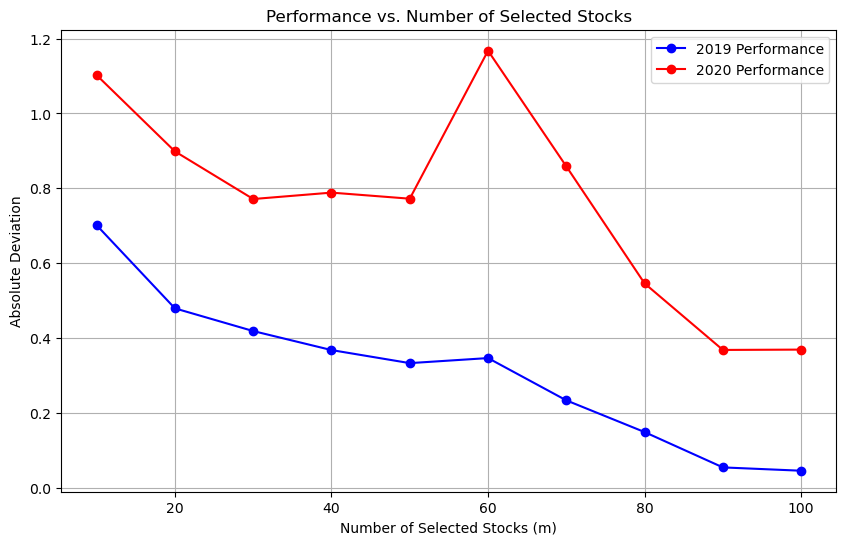

In [22]:
# Create a line chart to visualize the results
plt.figure(figsize=(10, 6))

# Plot the 2019 performance
plt.plot(no_of_stocks, abs_deviation_2019, marker='o', label='2019 Performance', color='blue')

# Plot the 2020 performance
plt.plot(no_of_stocks, abs_deviation_2020, marker='o', label='2020 Performance', color='red')

plt.xlabel('Number of Selected Stocks (m)')
plt.ylabel('Absolute Deviation')
plt.title('Performance vs. Number of Selected Stocks')
plt.legend()
plt.grid(True)

plt.show()


We see a downward trend of the sum of absolute difference between returns for both 2019 and 2020 with an exception at m = 60. The difference between the Index and the Portfolio is always lesser in 2019 than in 2020 as we have constructed our weights by using 2019 data.

The 2020 data reveals some intersting trends. Notably, there is a pronounced 49.23% inncrease in deviation when transitioning from 30 to 60 stocks. This increase signifies that, in this specific case, a smaller selection of stocks is preferable. 

There is also a 41% spike in deviation from 50 to 60 stocks, reinforcing the appeal of the 30-stock option. 

This preference is substantiated further by examining the 2019 data, where deviation of 60-stock model is only 17.49% lower than that of the 30-stock model.

Another viable alternative is to consider the 70-stock fund, which consistently exhibits a very similar deviation to the 80-stock option. Furthermore, the 90-stock model delivers the lowest deviation for the year 2020, suggesting that this configuration may permit special attention.

In summary, the analysis of different 'm' values underscores the nuanced relationship between the number of selected stocks and performance. The spike observed at m=60 higlights a pivotal point of diminishing returns, emphasizing the significance of optimizing the selection to ensure the best outcomes for our fund.

<div class="alert alert-block alert-info">
    
<strong>Q4:</strong> 

Now, if we try to re-do the same problem. But in this case, we will not attempt to select the stocks before the weight contribution determination for the same.

For this optimization problem, our objective is to minimize the difference between our m-stock portfolio and the entire index. We work with 251 {stocks_return_difference_X} continuous variables and 100 {stocks_weight_X} continuous variables and 100 {stocks_presence_X} binary variables to achieve this goal.

- The {stocks_return_difference_X} variables represent the difference between the m-stock portfolio and the entire index for a particular day.
- The {stocks_weight_X} variables represent the weight contribution of the stock to the m-stock fund.
- The {stocks_presence_X} variables represent the selection of the stock to the m-stock fund.

To satisfy the necessary constraints:


1. The first constraint ensures that m stocks weights must add up to 1.
   ∑ stocks_presence_X[i] = 1, for i = 1 to m

2. The second constraint is on part to ensure the non-linearity constraint for the minimization of the stock return difference.
   stocks_return_difference_X[i]>= q[i] - ∑ stocks_weight_X[j]*r𝑖t for i = 1, 2, ..., n, and j = 1 to n

3. The third constraint is on part to ensure the non-linearity constraint for the minimization of the stock return difference.
   stocks_return_difference_X[i]>= -q[i] + ∑ stocks_weight_X[j]*r𝑖t for i = 1, 2, ..., n, and j = 1 to n

4. The fourth constraint is to ensure that the weight contribution is set only if a stock is selected.
   (stocks_weight_X[i] <=M*stocks_presence_X[i]) for i = 1, 2, ..., n, and j = 1 to n

5. The fifth constraint ensures that m stocks weights must add up to 1.
   ∑ stocks_weight_X[i] = 1, for i = 1 to m


In [21]:
#get the number of stock returns
m=5

no_of_rows = len(stocks_2019)
no_of_rows_2020 = len(stocks_2020)

Index_column_name = stocks_2019.columns[1]

#initializing the model in Gurobi
stocks_weight_model=gp.Model()

stocks_weight_model.Params.TimeLimit = gurobi_time_limit

#Creating the decision variables for the model
stocks_return_difference_X = stocks_weight_model.addMVar(no_of_rows,vtype='C')

stocks_weight_X = stocks_weight_model.addMVar(len(stocks_available),vtype='C')

stocks_presence_X = stocks_weight_model.addMVar(len(stocks_available),vtype='B')

#Adding the objective function for the model
stocks_weight_model.setObjective(gp.quicksum(stocks_return_difference_X[i] for i in range(no_of_rows)),sense=gp.GRB.MINIMIZE)

#Adding the constraints for the model
stocks_weight_cons=[0]*5

M = 2*len(stocks_available)

stocks_weight_cons[0] = stocks_weight_model.addConstr(gp.quicksum(stocks_presence_X[i] for i in range(len(stocks_available))) == m)
stocks_weight_cons[1] = stocks_weight_model.addConstrs(stocks_return_difference_X[i]>= stocks_2019[Index_column_name+"_return"][i] - gp.quicksum(stocks_weight_X[j]*stocks_2019.iloc[i,j+ 2+ len(stocks_available)] for j in range(len(stocks_available)) ) for i in range(no_of_rows))
stocks_weight_cons[2] = stocks_weight_model.addConstrs(stocks_return_difference_X[i]>= - stocks_2019[Index_column_name+"_return"][i] + gp.quicksum(stocks_weight_X[j]*stocks_2019.iloc[i,j+ 2+ len(stocks_available)] for j in range(len(stocks_available)) ) for i in range(no_of_rows))
stocks_weight_cons[3] = stocks_weight_model.addConstrs((stocks_weight_X[i] <=M*stocks_presence_X[i]) for i in range(len(stocks_available)) )
stocks_weight_cons[4] = stocks_weight_model.addConstr(gp.quicksum(stocks_weight_X[i] for i in range(len(stocks_available))) == 1)

stocks_weight_model.Params.OutputFlag = 0 # tell gurobi to shut up!!
stocks_weight_model.optimize() #Solving the model

print("Optimization Status is :",stocks_weight_model.Status)

# Calculate the absolute deviation of the index fund 
absolute_deviation_2019 = sum(abs(stocks_2019.iloc[i][Index_column_name+"_return"] - sum(stocks_weight_X.x[j] * stocks_2019.iloc[i][j+2+len(stocks_available)] for j in range(len(stocks_available))))
                            for i in range(no_of_rows))

print("Absolute Deviation for 2019: ", absolute_deviation_2019)

# Calculate the absolute deviation of the index fund from NASDAQ for 2020
absolute_deviation_2020 = sum(abs(stocks_2020.iloc[i][Index_column_name+"_return"] - sum(stocks_weight_X.x[j] * stocks_2020.iloc[i][j+2+len(stocks_available)] for j in range(len(stocks_available))))
                            for i in range(no_of_rows_2020))

print("Absolute Deviation for 2020: ", absolute_deviation_2020)

Set parameter TimeLimit to value 3600


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Optimization Status is : 9
Absolute Deviation for 2019:  0.49925869205463486
Absolute Deviation for 2020:  0.7773624845503468


In [25]:
#show the selected stocks 
selected_stocks = stocks_available[np.where(stocks_presence_X.x)]
selected_stocks_position = np.where(stocks_presence_X.x) 

selected_stocks

Index(['AMZN', 'ADI', 'AAPL', 'MSFT', 'MDLZ'], dtype='object')

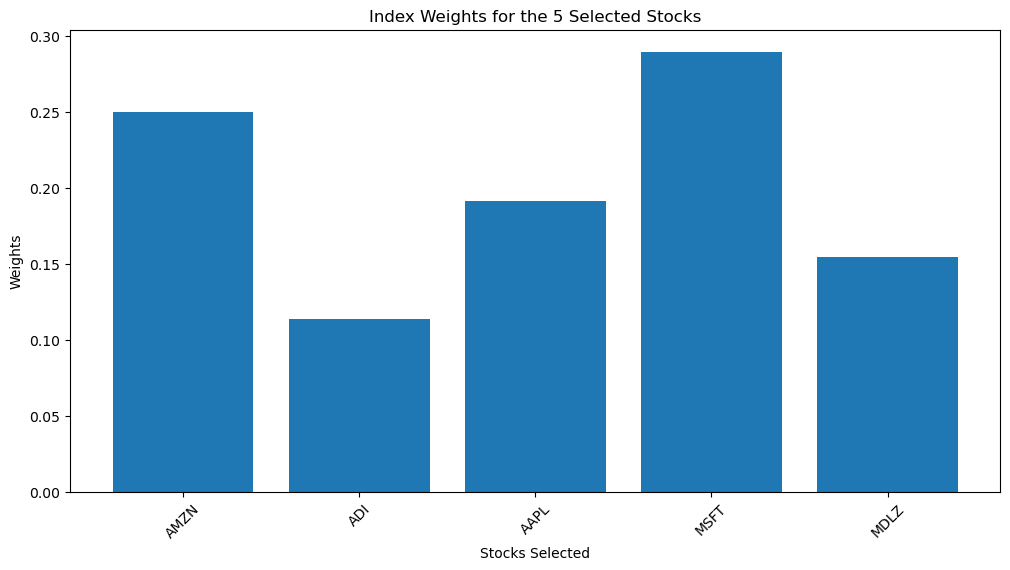

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(selected_stocks, stocks_weight_X.x[selected_stocks_position])
plt.title("Index Weights for the 5 Selected Stocks")
plt.xlabel("Stocks Selected")
plt.ylabel("Weights")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

<Axes: title={'center': 'Performance Evaluation on m=5'}, xlabel='Year', ylabel='Total Absolute Deviation'>

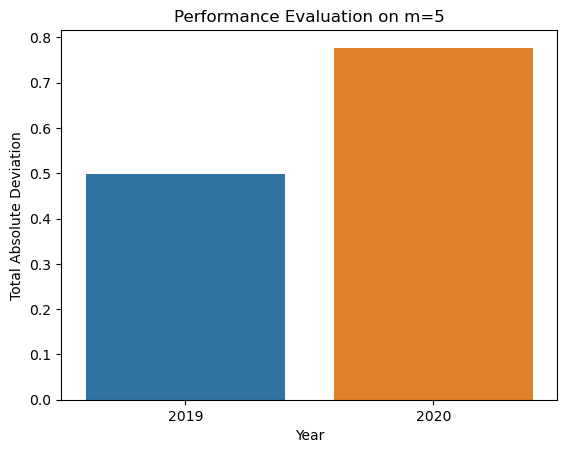

In [27]:
plt.title("Performance Evaluation on m=5")
plt.xlabel("Year")
plt.ylabel("Total Absolute Deviation")
sn.barplot(x = [2019,2020], y = [absolute_deviation_2019,absolute_deviation_2020])

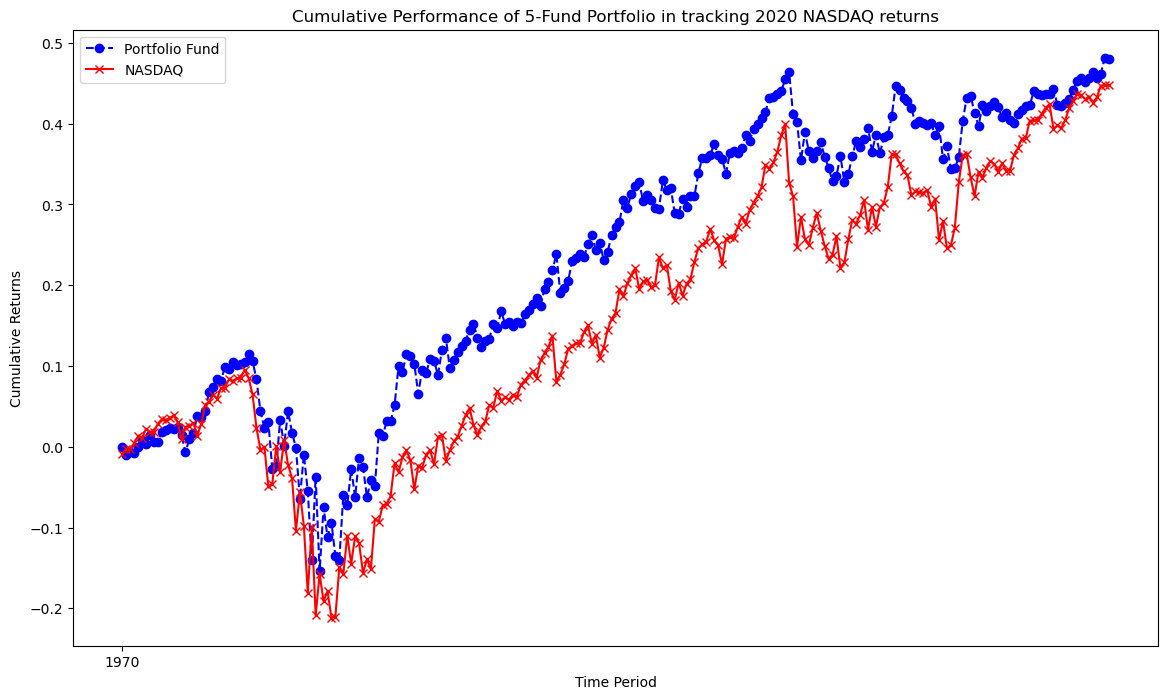

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

returns_timeline = pd.to_datetime(stocks_2020.index)
weighted_returns = []

# Computing weighted returns
cumulative_portfolio_returns = []  # Store cumulative returns here
cumulative_portfolio_return = 0

for i in range(no_of_rows):
    wr = 0
    for j in range(len(selected_stocks)):
        wr = wr + (stocks_weight_X.x[selected_stocks_position[0][j]] * stocks_2020.iloc[i][selected_stocks_position[0][j]+2+len(stocks_available)])
    weighted_returns.append(wr)
    cumulative_portfolio_return = cumulative_portfolio_return + wr  # Accumulate daily returns
    cumulative_portfolio_returns.append(cumulative_portfolio_return)

# Ensure both arrays have the same length
if len(returns_timeline) > len(cumulative_portfolio_returns):
    returns_timeline = returns_timeline[:-1]  # Remove the last date
elif len(cumulative_portfolio_returns) > len(returns_timeline):
    cumulative_portfolio_returns = cumulative_portfolio_returns[:-1]  # Remove the last value

# Calculate cumulative returns for NASDAQ
cumulative_nasdaq_returns = np.cumprod(1 + stocks_2020[Index_column_name+"_return"][1:]) - 1

# Plotting
plt.figure(figsize=(14, 8))
plt.plot(returns_timeline, cumulative_portfolio_returns, marker='o', linestyle='dashed', color='blue', label='Portfolio Fund')
plt.plot(returns_timeline, cumulative_nasdaq_returns, marker='x', color='red', label='NASDAQ')

plt.title("Cumulative Performance of 5-Fund Portfolio in tracking 2020 NASDAQ returns")
plt.xlabel('Time Period')
plt.ylabel('Cumulative Returns')
plt.legend()

plt.show()


Following our model run with 'm = 5,' we've identified a compelling selection of stocks that have significant relevance within the index. These five chosen stocks span a diverse spectrum of industries and companies, each bringing distinctive attributes to our portfolio.

Here is a detailed overview of the five selected stocks, providing insights into the respective companies and the industries they represent:

| *Selected Stocks* | *Company* | *Industry* |
|---------------------|-------------|--------------|
| AMZN                | Amazon.com Inc | E-Commerce and Cloud Computing |
| ADI                 | Analog Devices Inc | Semiconductor Manufacturing |
| AAPL                | Apple Inc | Technology and Consumer Electronics |
| MSFT                | Microsoft Corporation | Information Technology |
| MDLZ                | Mondelez International Inc | Food and Snack Manufacturing |

These selected stocks collectively encapsulate a rich tapestry of industries, from e-commerce and technology to consumer electronics and snack manufacturing. Such diversity in sector representation forms the cornerstone of a well-balanced portfolio.

Our analysis involved the initial exploration of the 2019 dataset, during which our model pinpointed these stocks for inclusion. Subsequently, leveraging linear programming, we precisely determined the weight allocation for each of the selected stocks. The resulting weight distribution for these stocks is as follows:

| *Selected Stocks* | *Weights* |
|---------------------|-------------|
| AMZN                | 0.25        |
| ADI                 | 0.12        |
| AAPL                | 0.19        |
| MSFT                | 0.28        |
| MDLZ                | 0.16        |

It's noteworthy that within the NASDAQ-100 index, technology behemoths like Amazon, Apple, and Microsoft hold considerable weight. Our strategic decision to assign significant weight to these stocks within our portfolio aligns it closely with the composition of the NASDAQ-100 index. By mirroring the weightings of key constituents such as Amazon, Apple, and Microsoft, our portfolio closely mirrors the performance and attributes of the NASDAQ-100, making it an effective strategy for replicating the index's behavior.

In conclusion, this thoughtfully selected group of stocks, along with their strategic weight distribution, positions our portfolio to closely mimic the NASDAQ-100's performance, providing us with an optimal foundation for replicating the index's behavior and characteristics.

Now, we try to evaluate the performance of the model by varying m

In [24]:
#Setting the number of stocks for the fund
no_of_selected_stocks = [5, 10, 20, 30, 40 ,50, 60, 70, 80, 90, 100]

no_of_stocks=[]
abs_deviation_2019=[]
abs_deviation_2020=[]

for m in no_of_selected_stocks:
    #get the number of stock returns
    no_of_rows = len(stocks_2019)
    no_of_rows_2020 = len(stocks_2020)

    Index_column_name = stocks_2019.columns[1]

    #initializing the model in Gurobi
    stocks_weight_model=gp.Model()

    stocks_weight_model.Params.TimeLimit = gurobi_time_limit

    #Creating the decision variables for the model
    stocks_return_difference_X = stocks_weight_model.addMVar(no_of_rows,vtype='C')

    stocks_weight_X = stocks_weight_model.addMVar(len(stocks_available),vtype='C')

    stocks_presence_X = stocks_weight_model.addMVar(len(stocks_available),vtype='B')

    #Adding the objective function for the model
    stocks_weight_model.setObjective(gp.quicksum(stocks_return_difference_X[i] for i in range(no_of_rows)),sense=gp.GRB.MINIMIZE)

    #Adding the constraints for the model
    stocks_weight_cons=[0]*5

    M = 2*len(stocks_available)

    stocks_weight_cons[0] = stocks_weight_model.addConstr(gp.quicksum(stocks_presence_X[i] for i in range(len(stocks_available))) == m)
    stocks_weight_cons[1] = stocks_weight_model.addConstrs(stocks_return_difference_X[i]>= stocks_2019[Index_column_name+"_return"][i] - gp.quicksum(stocks_weight_X[j]*stocks_2019.iloc[i,j+ 2+ len(stocks_available)] for j in range(len(stocks_available)) ) for i in range(no_of_rows))
    stocks_weight_cons[2] = stocks_weight_model.addConstrs(stocks_return_difference_X[i]>= - stocks_2019[Index_column_name+"_return"][i] + gp.quicksum(stocks_weight_X[j]*stocks_2019.iloc[i,j+ 2+ len(stocks_available)] for j in range(len(stocks_available)) ) for i in range(no_of_rows))
    stocks_weight_cons[3] = stocks_weight_model.addConstrs((stocks_weight_X[i] <=M*stocks_presence_X[i]) for i in range(len(stocks_available)) )
    stocks_weight_cons[4] = stocks_weight_model.addConstr(gp.quicksum(stocks_weight_X[i] for i in range(len(stocks_available))) == 1)

    stocks_weight_model.Params.OutputFlag = 0 # tell gurobi to shut up!!
    stocks_weight_model.optimize() #Solving the model

    print("Optimization Status is :",stocks_weight_model.Status)

    # Calculate the absolute deviation of the index fund 
    absolute_deviation_2019 = sum(abs(stocks_2019.iloc[i][Index_column_name+"_return"] - sum(stocks_weight_X.x[j] * stocks_2019.iloc[i][j+2+len(stocks_available)] for j in range(len(stocks_available))))
                                for i in range(no_of_rows))

    print("Absolute Deviation for 2019: ", absolute_deviation_2019)

    # Calculate the absolute deviation of the index fund from NASDAQ for 2020
    absolute_deviation_2020 = sum(abs(stocks_2020.iloc[i][Index_column_name+"_return"] - sum(stocks_weight_X.x[j] * stocks_2020.iloc[i][j+2+len(stocks_available)] for j in range(len(stocks_available))))
                                for i in range(no_of_rows_2020))

    print("Absolute Deviation for 2020: ", absolute_deviation_2020)

    no_of_stocks.append(m)
    abs_deviation_2019.append(absolute_deviation_2019)
    abs_deviation_2020.append(absolute_deviation_2020)

abs_deviation_df= pd.DataFrame({"no_of_stocks": no_of_stocks, "abs_deviation_2019":abs_deviation_2019, "abs_deviation_2020":abs_deviation_2020})

abs_deviation_df.to_csv("Opti_Proj_Q4.csv")

Set parameter TimeLimit to value 3600
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Optimization Status is : 9
Absolute Deviation for 2019:  0.49925869205463486
Absolute Deviation for 2020:  0.7773624845503468
Set parameter TimeLimit to value 3600
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Optimization Status is : 9
Absolute Deviation for 2019:  0.3011728551326467
Absolute Deviation for 2020:  0.6983245553352659
Set parameter TimeLimit to value 3600
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Optimization Status is : 9
Absolute Deviation for 2019:  0.16210629580998165
Absolute Deviation for 2020:  0.5307490016940248
Set parameter TimeLimit to value 3600
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Optimization Status is : 9
Absolute Deviation for 2019:  0.10607073043399345
Absolute Deviation for 2020:  0.47736949366100756
Set parameter TimeLimit to value

Absolute Deviation of Portfolio Fund with NASDAQ for 2019 and 2020 for various values of m:

       Performance on 2019 Data  Performance on 2020 Data
m                                                        
5.0                    0.499259                  0.777362
10.0                   0.301173                  0.698325
20.0                   0.162106                  0.530749
30.0                   0.106071                  0.477369
40.0                   0.078695                  0.441190
50.0                   0.061052                  0.406813
60.0                   0.052524                  0.377050
70.0                   0.047524                  0.362546
80.0                   0.045227                  0.370612
90.0                   0.044911                  0.368682
100.0                  0.044911                  0.368682


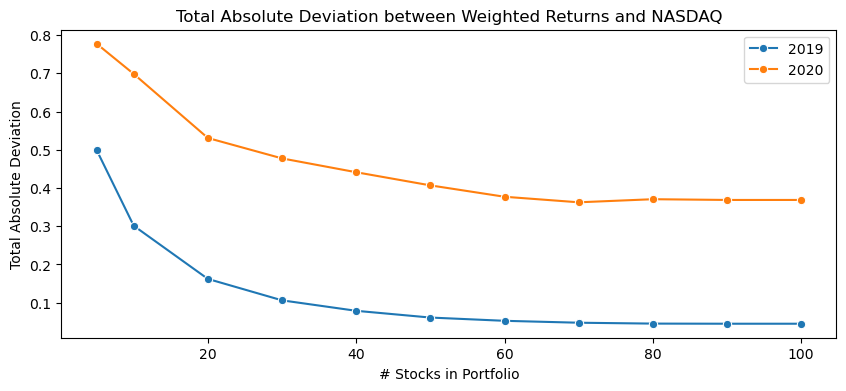

In [28]:

import seaborn as sns

# Create a DataFrame to store the results
performance_df = pd.DataFrame(data=[no_of_stocks, abs_deviation_2019, abs_deviation_2020]).T
performance_df.rename(columns={0: 'm', 1: 'Performance on 2019 Data', 2: 'Performance on 2020 Data'}, inplace=True)
performance_df = performance_df.set_index('m')

# Print the performance DataFrame
print("Absolute Deviation of Portfolio Fund with NASDAQ for 2019 and 2020 for various values of m:\n")
print(performance_df)

# Convert the performance data to NumPy arrays
perf_2019 = np.array(abs_deviation_2019)
perf_2020 = np.array(abs_deviation_2020)

# Create a line plot to visualize the data
plt.figure(figsize=(10, 4))
sns.lineplot(x=no_of_stocks, y=perf_2019, label="2019", marker="o")
sns.lineplot(x=no_of_stocks, y=perf_2020, label="2020", marker="o")
plt.title("Total Absolute Deviation between Weighted Returns and NASDAQ")
plt.xlabel("# Stocks in Portfolio")
plt.ylabel("Total Absolute Deviation")
plt.show()


The second method shows that as we increase the number of stocks in the fund (m), performance stabilizes and adding more stocks doesn't significantly improve performance. This behavior is in contrast to the first model, where we observed performance improvements with the addition of more stocks.

Furthermore, the second method results in smaller deviations compared to the first method. Therefore, the second method consistently delivers better and more stable performance. However, it's worth noting that the second method is computationally more intensive.

Around m=50, we observe an optimal selection of stocks, where performance stabilizes. This point represents an "elbow" in the 2020 performance graph. If we prefer a smaller number of stocks in the fund, 30 stocks appear to be a suitable choice, providing a balance between performance and simplicity.

In summary, the second method's performance stability and lower deviation make it a preferable choice, and the choice of the optimal number of stocks depends on specific preferences and trade-offs.

* Our recommendation to maximize cumulative returns is to use the Mixed-Integer Programming (MIP) method, and here's why. When we compare the cumulative returns for the Integer Programming/Linear Programming (IP/LP) and MIP methods, we observe that the MIP method closely tracks the index for a wide range of selected stocks. This trend is supported by the total absolute deviation plots for both 2019 and 2020, where the MIP method's curves remain relatively smooth over the range of 'm' values. In contrast, the IP/LP method exhibits jagged deviations, and it only reaches its lowest deviation after selecting over 80 stocks. The MIP method, on the other hand, begins to level out somewhere between 40 and 60 selected stocks. This superior accuracy comes at the cost of increased computational time, making MIP more time-consuming than IP/LP.

* Now that we've recommended the MIP method for selecting weights, let's determine the optimal number of stocks to select using MIP. Analyzing the total absolute deviation for the MIP method, we find that the deviation from the index stabilizes between 40 and 60 selected stocks. Beyond this range, there's little additional benefit gained from adding more stocks to the portfolio. Therefore, our recommendation is to select at most 60 stocks in the MIP model to closely replicate the index with the least computational effort.

* In evaluating the two approaches, Method 2 consistently outperforms Method 1 across different values of 'm', delivering significantly reduced errors. The performance of Method 2 appears to peak around m = 50 and then stabilizes, while Method 1 exhibits higher variability and continues to improve as 'm' increases. Hence, we strongly endorse Method 2 for constructing our Index fund to replicate the NASDAQ-100.

* Our recommendation is to set 'm' at approximately 30, where we observe an inflection or "elbow" in the performance graph. This number of stocks in our fund ensures a reasonable replication of the NASDAQ-100. If the costs associated with adding more stocks to our portfolio, including rebalancing costs and price response to trading, are manageable, we can consider increasing 'm'. The precise value of 'm' should be refined by weighing the trade-offs between portfolio expansion costs and the costs associated with tracking error when mirroring the NASDAQ-100.

* It's important to note that Method 2 requires significantly more computational resources and time. Method 1 should be considered only when there are insurmountable resource constraints for constructing our Index fund. To assist your decision-making, we've provided visualizations that illustrate the comparative performance of both methods across different 'm' values. This data-driven analysis empowers you to make an informed choice aligned with our fund's objectives and resource constraints.